In [2]:
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm

# matplotlib default
c_map_list        = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
c_map_list_darker = ['#174d71', '#b25807', '#1d6e1d', '#941b1c', '#684f8d', '#6a4538', '#ab5c9b', '#5a5a5a', '#8c8e18', '#12969c']
linestyle_list = ['solid', 'dotted', 'dashed', 'dashdot']
figure_dir = 'figures'
os.makedirs(figure_dir, exist_ok=True)

# Figures

In [34]:
dataset_name = 'count'
if dataset_name == 'cifar':
    model_type = 'ctmc'
    nfe_list = [16, 32, 64, 128, 256]
    max_length = 3*32*32
if dataset_name == 'count':
    model_type = 'sedd'
    nfe_list = [2, 4, 8, 16, 32]
    max_length = 256
if dataset_name == 'text':
    model_type = 'sedd'
    nfe_list = [16, 32, 64, 128, 256]
    max_length = 1024
scheduler_list = ["euler"]

/tmp/ipykernel_215053/699419669.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


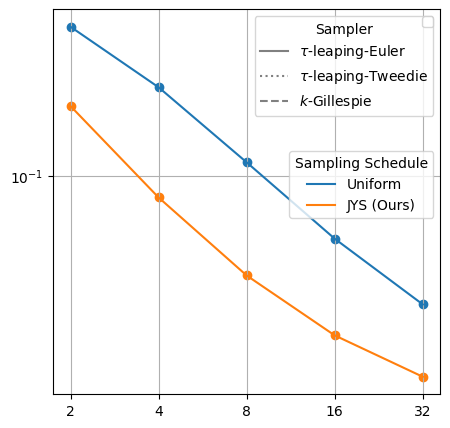

In [35]:
def get_result(result):
    if isinstance(result, torch.Tensor):
        assert len(result.shape) == 0
        return result.item()
    elif isinstance(result, float):
        return result
    else:
        raise ValueError(f'Unknown result type: {type(result)}')
    
fig, axs = plt.subplots(1, 1, figsize=(5,5))
for scheduler in scheduler_list:
    for scheduler_i, scheduler in enumerate(scheduler_list):
        src_nfe = 256 if scheduler == 'gillespie' else 1024
        
        result_list = []
        for nfe in nfe_list:
            result = torch.load(f'runs-eval/{dataset_name}-{model_type}-{scheduler}/x0_eval-uniform-tgt_nfe_{nfe}-src_nfe_{src_nfe}-seed_42-max_length_{max_length}.pt')
            result_list.append(get_result(result))
        axs.plot(nfe_list, result_list, linestyle=linestyle_list[scheduler_i], c=c_map_list[0])
        axs.scatter(nfe_list, result_list, c=c_map_list[0])

        result_list = []
        for nfe in nfe_list:
            result = torch.load(f'runs-eval/{dataset_name}-{model_type}-{scheduler}/x0_eval-jys-tgt_nfe_{nfe}-src_nfe_{src_nfe}-seed_42-max_length_{max_length}.pt')
            result_list.append(get_result(result))
        axs.plot(nfe_list, result_list, linestyle=linestyle_list[scheduler_i], c=c_map_list[1])
        axs.scatter(nfe_list, result_list, c=c_map_list[1])

legend_elements1 = [
    Line2D([0], [0], color=c_map_list[0], label='Uniform'),
    Line2D([0], [0], color=c_map_list[1], label='JYS (Ours)'),
]
legend1 = axs.legend(
    handles=legend_elements1, title='Sampling Schedule', loc='upper right', fontsize='medium', title_fontsize='medium', frameon=True,
    bbox_to_anchor=(1, 0.65)
)
axs.add_artist(legend1)

legend_elements2 = [
    Line2D([0], [0], color='gray', linestyle=linestyle_list[0], label=r'$\tau$-leaping-Euler'),
    Line2D([0], [0], color='gray', linestyle=linestyle_list[1], label=r'$\tau$-leaping-Tweedie'),
    Line2D([0], [0], color='gray', linestyle=linestyle_list[2], label=r'$k$-Gillespie'),
]
legend2 = axs.legend(
    handles=legend_elements2, title='Sampler', loc='upper right', fontsize='medium', title_fontsize='medium', frameon=True,
    bbox_to_anchor=(1, 1)
)
axs.add_artist(legend2)

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.minorticks_off()
plt.xticks(nfe_list, nfe_list)
plt.setp(axs, xticks=nfe_list, xticklabels=nfe_list)

# plt.savefig(f'{figure_dir}/{dataset_name}.svg')
plt.show()

In [ ]:
import torch_fidelity
import torch
from tqdm import tqdm

scheduler_list = ["euler"]
new_nfe_list = []

fig, axs = plt.subplots(1, 1, figsize=(5,5))
for scheduler_i, scheduler in enumerate(scheduler_list):
    src_nfe = 256 if scheduler == 'gillespie' else 1024
    
    result_dict = torch.load(f'../results/cifar10-{scheduler}-uniform-fid.pt')
    nfe_list, result_list = result_dict['nfe_list'], result_dict['result_list']
    
    for i, nfe in tqdm(enumerate(new_nfe_list), desc='uniform...'):
        metrics_dict = torch_fidelity.calculate_metrics(
            input1=f'/data/yonghyun/runs-gen_x0_0923/cifar-ctmc-{scheduler}/x0_gen-uniform-tgt_nfe_{nfe}-src_nfe_1024.pt', 
            input2='cifar10-train', 
            gpu=3, 
            cuda=True, 
            fid=True, 
            prc=False, 
            verbose=False,
        )
        nfe_list.insert(i, nfe)
        result_list.insert(i, metrics_dict['frechet_inception_distance'])
        # result_list.append(metrics_dict['frechet_inception_diste'])
    # torch.save({'nfe_list': nfe_list, 'result_list': result_list}, f'../results/cifar10-{scheduler}-uniform-fid.pt')

    # nfe_list += [512]
    # result_list += [18.30995601070032]

    axs.plot(nfe_list, result_list, linestyle=linestyle_list[scheduler_i], c=c_map_list[0])
    axs.scatter(nfe_list, result_list, c=c_map_list[0])

    result_dict = torch.load(f'../results/cifar10-{scheduler}-klub-gibbs-fid.pt')
    nfe_list, result_list = result_dict['nfe_list'], result_dict['result_list']

    for i, nfe in tqdm(enumerate(new_nfe_list), desc='klub gibbs...'):
        metrics_dict = torch_fidelity.calculate_metrics(
            input1=f'/data/yonghyun/runs-gen_x0_0923/cifar-ctmc-euler/x0_gen-klub-gibbs-tgt_nfe_{nfe}-src_nfe_1024.pt', 
            input2='cifar10-train', 
            gpu=3, 
            cuda=True, 
            fid=True, 
            prc=False, 
            verbose=False,
        )
        nfe_list.insert(i, nfe)
        result_list.insert(i, metrics_dict['frechet_inception_distance'])
        # result_list.append(metrics_dict['frechet_inception_distance'])
    # torch.save({'nfe_list': nfe_list, 'result_list': result_list}, f'../results/cifar10-{scheduler}-klub-gibbs-fid.pt')
    
    # nfe_list += [512]
    # result_list += [10.817257623601051]

    axs.plot(nfe_list, result_list, linestyle=linestyle_list[scheduler_i], c=c_map_list[1])
    axs.scatter(nfe_list, result_list, c=c_map_list[1])

legend_elements1 = [
    Line2D([0], [0], color=c_map_list[0], label='Uniform'),
    Line2D([0], [0], color=c_map_list[1], label='JYS (Ours)'),
]
legend1 = axs.legend(
    handles=legend_elements1, title='Sampling Schedule', loc='upper right', fontsize='medium', title_fontsize='medium', frameon=True,
    bbox_to_anchor=(1, 0.85)
)
axs.add_artist(legend1)

legend_elements2 = [
    Line2D([0], [0], color='gray', linestyle=linestyle_list[0], label=r'$\tau$-leaping-Euler'),
    # Line2D([0], [0], color='gray', linestyle=linestyle_list[1], label=r'$\tau$-leaping-Tweedie'),
    # Line2D([0], [0], color='gray', linestyle=linestyle_list[2], label=r'$k$-Gillespie'),
]
legend2 = axs.legend(
    handles=legend_elements2, title='Sampler', loc='upper right', fontsize='medium', title_fontsize='medium', frameon=True,
    bbox_to_anchor=(1, 1)
)
axs.add_artist(legend2)

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.minorticks_off()
plt.xticks(nfe_list, nfe_list)
plt.setp(axs, xticks=nfe_list, xticklabels=nfe_list)

plt.savefig(f'{figure_dir}/cifar10.svg')
